In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
warnings.filterwarnings('ignore')
from typing import List

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
from torchaudio.transforms import MelSpectrogram
from torchaudio.models import WaveRNN
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [4]:
import matplotlib
# matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5

In [80]:
import numpy as np
import IPython.display as ipd
from tqdm import tqdm
import pandas as pd
import librosa
import librosa.display
from scipy.io import wavfile

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

In [8]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

In [9]:
def plot_waveform_n_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 2, figsize=(10, 2))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c][0].plot(time_axis, waveform[c], linewidth=1)
        axes[c][0].set_ylim([-1.0, 1.0])
        axes[c][1].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c][0].set_ylabel(f"Channel {c+1}")
            axes[c][1].set_ylabel(f"Channel {c+1}")
        axes[c][0].set_title('Waveform')
        axes[c][1].set_title('Spectrogram')

In [84]:
save_flag = False
n_channels = 10
sample_rate = 16000

# Speech Commands Dataset

In [11]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, data_root, subset: str = None):
        super().__init__(data_root, download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [12]:
# Create training and testing split of the data. We do not use validation in this tutorial.
fg_train_set = SubsetSC('/data/home/geshi/data/', "training")
fg_val_set = SubsetSC('/data/home/geshi/data/', "validation")
fg_test_set = SubsetSC('/data/home/geshi/data/', "testing")

waveform, sample_rate, label, speaker_id, utterance_number = fg_train_set[0]

In [13]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print("dataset size train {}, val {}, test {}".format(len(fg_train_set), len(fg_val_set), len(fg_test_set)))

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000
dataset size train 84843, val 9981, test 11005


In [14]:
labels = sorted(list(set(datapoint[2] for datapoint in fg_train_set)))
print("number of classes", len(labels))

number of classes 35


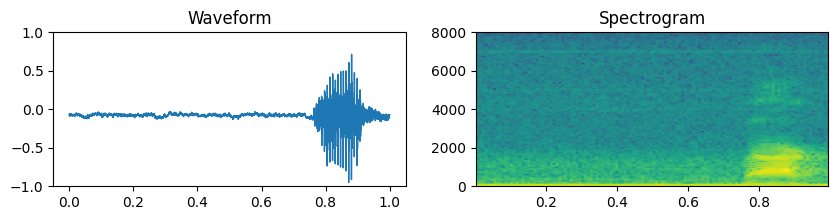

In [15]:
plot_waveform_n_specgram(waveform, sample_rate)
if save_flag:
    plt.savefig('../command.png',dpi=300)

In [16]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

# Noisy Background

In [17]:
noise_channel = torch.clamp(torch.randn_like(waveform)*0.25, min=-1, max=1)

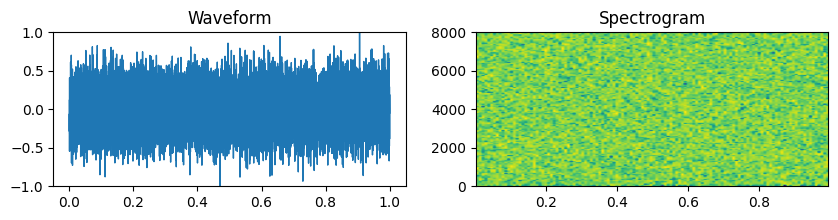

In [18]:
plot_waveform_n_specgram(noise_channel, sample_rate)
if save_flag:
    plt.savefig('../audio_noise.png',dpi=300)

In [19]:
ipd.Audio(noise_channel.numpy(), rate=sample_rate)

# Rain Forest Species Audio Dataset

In [20]:
df = pd.read_csv('/data/home/geshi/data/rfcx-species-audio-detection/train_tp.csv')

In [21]:
df.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [67]:
sample_num=200 #pick a file to display
filename=df.recording_id[sample_num]+str('.flac') #get the filename
#define the beginning time of the signal
tstart = df.t_min[sample_num] 
tend = df.t_max[sample_num] #define the end time of the signal
y,sr=librosa.load('/data/home/geshi/data/rfcx-species-audio-detection/train/'+str(filename))
# librosa.display.waveplot(y,sr=sr, x_axis='time', color='purple',offset=0.0)

In [68]:
y = torch.tensor(y)
y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=sample_rate)

In [69]:
pos = random.randint(0, len(y)//sample_rate)

In [70]:
max_volume = torch.abs(y).quantile(0.99)

In [71]:
bg_waveform = torch.clamp(y[pos*sample_rate:(pos+1)*sample_rate]/max_volume, min=-1, max=1)

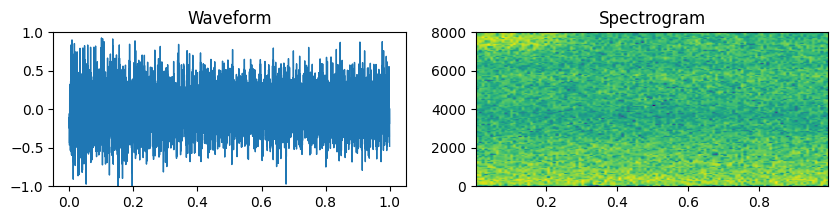

In [72]:
plot_waveform_n_specgram(bg_waveform.unsqueeze(0), sample_rate)
if save_flag:
    plt.savefig('../forest.png',dpi=300)

In [73]:
ipd.Audio(bg_waveform.numpy(), rate=sample_rate)

# Generate Synthetic Audio Data

## Random Background Fixed Position

In [81]:
fg_random_id = random.randint(0, len(fg_train_set))

In [85]:
fg_waveform, fg_sample_rate, label, speaker_id, utterance_number = fg_train_set[fg_random_id]

In [86]:
fg_waveform = torchaudio.functional.resample(fg_waveform, orig_freq=fg_sample_rate, new_freq=sample_rate)

In [87]:
sample = np.clip(np.random.normal(0, 1, (sample_rate, n_channels))*0.25, a_min=-1, a_max=1)

In [88]:
sample[:,0] = fg_waveform.squeeze()

In [91]:
wavfile.write("../RBFP_example.wav", sample_rate, sample)

In [92]:
reload_samplerate, reload_data = wavfile.read("../RBFP_example.wav")

In [100]:
ipd.Audio(reload_data[:,0], rate=reload_samplerate)

## Random Background Random Position

In [101]:
fg_random_id = random.randint(0, len(fg_train_set))

In [102]:
fg_waveform, fg_sample_rate, label, speaker_id, utterance_number = fg_train_set[fg_random_id]

In [103]:
fg_waveform = torchaudio.functional.resample(fg_waveform, orig_freq=fg_sample_rate, new_freq=sample_rate)

In [104]:
sample = np.clip(np.random.normal(0, 1, (sample_rate, n_channels))*0.25, a_min=-1, a_max=1)

In [105]:
random_pos = random.randint(0, n_channels)

In [106]:
sample[:,random_pos] = fg_waveform.squeeze()

In [107]:
wavfile.write("../RBRP_example.wav", sample_rate, sample)

In [108]:
reload_samplerate, reload_data = wavfile.read("../RBRP_example.wav")

In [109]:
ipd.Audio(reload_data[:,random_pos], rate=reload_samplerate)

## Structural Background Fixed Position

In [157]:
fg_random_id = random.randint(0, len(fg_train_set))

In [158]:
fg_waveform, fg_sample_rate, label, speaker_id, utterance_number = fg_train_set[fg_random_id]

In [159]:
fg_waveform = torchaudio.functional.resample(fg_waveform, orig_freq=fg_sample_rate, new_freq=sample_rate)

In [160]:
sample = np.clip(np.random.normal(0, 1, (sample_rate, n_channels))*0.25, a_min=-1, a_max=1)

In [161]:
sample[:,0] = fg_waveform.squeeze()

In [162]:
bg_train_folder = "/data/home/geshi/data/rfcx-species-audio-detection/train"
bg_test_folder = "/data/home/geshi/data/rfcx-species-audio-detection/test"

In [163]:
train_files = [name for name in os.listdir(bg_train_folder) if name.endswith('.flac')]
test_files = [name for name in os.listdir(bg_test_folder) if name.endswith('.flac')]

In [164]:
for i in range(1, n_channels):
    bg_random_id = random.randint(0, len(train_files))
    bg_waveform, bg_sample_rate = librosa.load(os.path.join(bg_train_folder, train_files[bg_random_id]), sr=sample_rate)

    bg_start = random.randint(0, len(bg_waveform)//sample_rate)
    max_volume = np.quantile(np.abs(bg_waveform), 0.99)
    bg_waveform = np.clip(bg_waveform[bg_start*sample_rate:(bg_start+1)*sample_rate]/max_volume, a_min=-1, a_max=1)
    sample[:,i] = bg_waveform.squeeze()

In [165]:
wavfile.write("../SBFP_example.wav", sample_rate, sample)

In [166]:
reload_samplerate, reload_data = wavfile.read("../SBFP_example.wav")

In [167]:
ipd.Audio(reload_data[:,0], rate=reload_samplerate)

## Structural Background Random Position

In [168]:
fg_random_id = random.randint(0, len(fg_train_set))

In [169]:
fg_waveform, fg_sample_rate, label, speaker_id, utterance_number = fg_train_set[fg_random_id]

In [170]:
fg_waveform = torchaudio.functional.resample(fg_waveform, orig_freq=fg_sample_rate, new_freq=sample_rate)

In [171]:
sample = np.clip(np.random.normal(0, 1, (sample_rate, n_channels))*0.25, a_min=-1, a_max=1)

In [172]:
random_pos = random.randint(0, n_channels)

In [173]:
sample[:,random_pos] = fg_waveform.squeeze()

In [174]:
for i in range(n_channels):
    if i==random_pos:
        continue
    bg_random_id = random.randint(0, len(train_files))
    bg_waveform, bg_sample_rate = librosa.load(os.path.join(bg_train_folder, train_files[bg_random_id]), sr=sample_rate)

    bg_start = random.randint(0, len(bg_waveform)//sample_rate)
    max_volume = np.quantile(np.abs(bg_waveform), 0.99)
    bg_waveform = np.clip(bg_waveform[bg_start*sample_rate:(bg_start+1)*sample_rate]/max_volume, a_min=-1, a_max=1)
    sample[:,i] = bg_waveform.squeeze()

In [175]:
wavfile.write("../SBRP_example.wav", sample_rate, sample)

In [176]:
reload_samplerate, reload_data = wavfile.read("../SBRP_example.wav")

In [177]:
ipd.Audio(reload_data[:,random_pos], rate=reload_samplerate)

In [189]:
length_size = set()

In [190]:
for fg_id in range(len(fg_train_set)):
    fg_waveform, fg_sample_rate, label, speaker_id, utterance_number = fg_train_set[fg_id]
    length_size.add(fg_waveform.shape[1])

In [193]:
length_size

{4096,
 4458,
 4778,
 5201,
 5461,
 5803,
 5944,
 5945,
 6144,
 6315,
 6687,
 6688,
 6826,
 6827,
 7168,
 7339,
 7430,
 7431,
 7509,
 7510,
 7680,
 7851,
 8022,
 8173,
 8174,
 8192,
 8363,
 8533,
 8534,
 8874,
 8875,
 8916,
 8917,
 9046,
 9216,
 9387,
 9557,
 9558,
 9659,
 9660,
 9728,
 9899,
 10032,
 10069,
 10070,
 10240,
 10402,
 10403,
 10411,
 10581,
 10582,
 10752,
 10922,
 10923,
 11093,
 11094,
 11145,
 11146,
 11264,
 11435,
 11605,
 11606,
 11776,
 11888,
 11889,
 11947,
 11972,
 11976,
 12052,
 12056,
 12117,
 12118,
 12132,
 12136,
 12212,
 12216,
 12261,
 12288,
 12292,
 12296,
 12376,
 12456,
 12459,
 12480,
 12536,
 12616,
 12629,
 12630,
 12631,
 12632,
 12696,
 12800,
 12852,
 12970,
 12971,
 13004,
 13141,
 13142,
 13312,
 13332,
 13375,
 13483,
 13653,
 13654,
 13824,
 13995,
 14118,
 14165,
 14166,
 14336,
 14372,
 14490,
 14507,
 14677,
 14678,
 14692,
 14772,
 14848,
 14861,
 15018,
 15019,
 15092,
 15172,
 15189,
 15190,
 15233,
 15360,
 15412,
 15492,
 15531,
 1